In [1]:
!pip install --upgrade tensorflow-estimator==2.3.0

In [2]:
import pandas as pd
from langdetect import detect
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub
import tensorflow_text
from tqdm import tqdm
import numpy as np
import seaborn as sns

In [3]:
def  to_num(string):
    if 'K' in string:
        return float(string.strip('K')) * 1000
    elif 'M' in string:
        return float(string.strip('M')) * 1000000
    elif 'views' in string:
        return int(string.split(' ')[0].replace(',',''))
    else:
        return float(string)
    
def clean_title(string):
    if '(' in string:
        string = string.split('(')[0]
    if 'Trailer' in string:
        string = string.replace('Trailer', '')
    return string

def lang(string):
    try:
        return detect(string)
    except:
        return 'Unknown'

## Cleaning and Feature Engineering
* created sentiment analysis for comment: positive/negative
* Parsed Strings into numbers
* Cleaned title of movies
* determined language of comment
* created like/dislike ratio

In [4]:
df = pd.read_csv('./Data/movie_trailer_comments.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

## add index column for passing comments in model later
df = df.reset_index()

## remove views, likes, dislikes and any info not relevant to the model
df.drop(['Views', 'Likes', 'Dislikes'], axis=1, inplace=True)

## Clean 'Title' String
df['Title'] = df['Title'].apply(lambda x: clean_title(x))

## Feature engineering 
## Language(LangDetect Comment)
## Comment Length(length of comment in characters)
df['Language'] = df['Comment'].apply(lambda x: lang(x))
df['Comment Length'] = df['Comment'].apply(lambda x: len(x))

df.to_csv('./Data/movie_trailer_comments_cleaned.csv')
df.head()

,index,Title,Comment,Language,Comment Length
0,0,DON'T BREATHE 2,Why do trailers these days reveal the entire p...,en,63
1,1,DON'T BREATHE 2,Can't believe that he is 68 years old. At this...,en,97
2,2,DON'T BREATHE 2,We sure this old man isn’t an Earthbender like...,en,52
3,3,DON'T BREATHE 2,He looks even better in the positive role,en,41
4,4,DON'T BREATHE 2,This feels like Terminator 2 the bad guy becom...,en,60


## Data preprocessing to run comments through model
* Create column for comment sentiment

In [5]:
model = tf.keras.models.load_model('./Model/saved_model/sentiment_analysis_model')

## load universal sentence encoder from tf hub
use = tensorflow_hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

## convert test reviews to embed vector
test_x = []
for i in tqdm(df['Comment']):
    emb = use(i)
    review_emb = tf.reshape(emb, [-1]).numpy()
    test_x.append(review_emb)
    
test_x = np.array(test_x)

100%|████████████████████████████████████████████████████████████████████████████████| 988/988 [00:28<00:00, 35.10it/s]


In [6]:
def get_sent(pred):
    if np.argmax(pred) == 0:
        return 'negative'
    else: 
        return 'positive'
    
rand_ind = [15, 150, 490, 600]

for i in rand_ind:
    print(df.iloc[i].Comment+'\n')
    label_pred = model.predict(test_x[i:i+1])
    print(label_pred)
    print(get_sent(label_pred)+'\n')

I'm soooo confused right now. Did he steal the kid from the main character in the first movie? Or is this a prequel?

[[0.9121796 0.0878204]]
negative

This plus Dune equals a happy sci-fi nerd. Now we just need Rendevous with Rama.

[[0.01862788 0.9813721 ]]
positive

If they lay a finger on Angel or Lydia, I'm rioting.

[[0.98009825 0.01990171]]
negative

He looks the same age as his dad

[[0.07805853 0.92194146]]
positive



In [7]:
def pred_sent(comment):
    i = df[df['Comment'] == comment].index
    pred = model.predict(test_x[i])
    return get_sent(pred)

df['Comment_Sentiment'] = df['Comment'].apply(lambda x: pred_sent(x))

df.to_csv('./movie_trailer_comments_sentiment.csv')

In [8]:
df.head()

,index,Title,Comment,Language,Comment Length,Comment_Sentiment
0,0,DON'T BREATHE 2,Why do trailers these days reveal the entire p...,en,63,positive
1,1,DON'T BREATHE 2,Can't believe that he is 68 years old. At this...,en,97,negative
2,2,DON'T BREATHE 2,We sure this old man isn’t an Earthbender like...,en,52,negative
3,3,DON'T BREATHE 2,He looks even better in the positive role,en,41,positive
4,4,DON'T BREATHE 2,This feels like Terminator 2 the bad guy becom...,en,60,negative


## Create TF-IDF matrix for WordCloud

In [9]:
# concatenate all comments into a corpus for vectorization
all_comments = df['Comment'].str.cat()
all_comments
corpus = [all_comments]
vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1), max_df = 1, min_df = .0001)
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
dense = X.todense()
denselist = dense.tolist()
# tf-idf matrix
tfidf_df = pd.DataFrame(denselist, columns=feature_names)

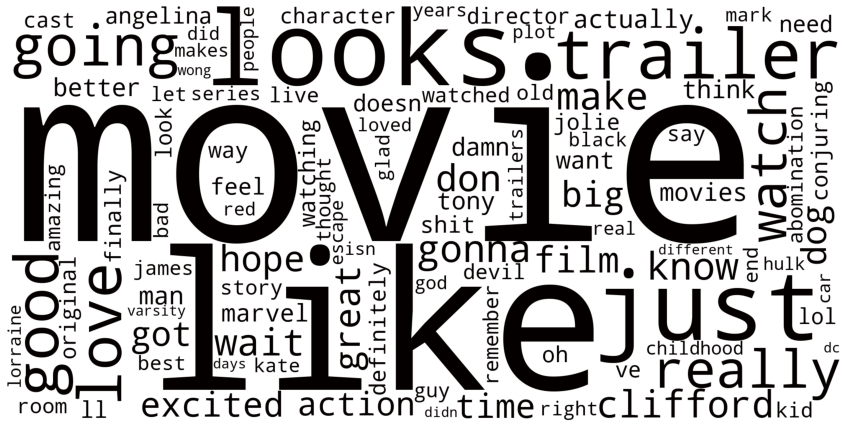

In [10]:
data = tfidf_df.transpose()
data.columns = ['comments']

# change the value to black
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

# set the wordcloud background color to white
# set max_words to 100
# set width and height to higher quality, 3000 x 2000
wordcloud = WordCloud(background_color="white", width=2000, height=1000, max_words=100).generate_from_frequencies(data['comments'])
# set the word color to black
wordcloud.recolor(color_func = black_color_func)
# set the figsize
plt.figure(figsize=[15,10])
# remove plot axes
plt.axis("off")

## plot wordcloud
plt.imshow(wordcloud)

<ipython-input-11-395cef319f08>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcount['Positive'] = dfcount['Comment_Sentiment'].apply(lambda x: binary(x, 'positive'))
<ipython-input-11-395cef319f08>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcount['Negative'] = dfcount['Comment_Sentiment'].apply(lambda x: binary(x, 'negative'))


,Title,Positive,Negative
15,THE MANY SAINTS OF NEWARK,62,26
17,THOSE WHO WISH ME DEAD Official,45,5
14,THE HARDER THEY FALL,40,10
9,JOLT,39,11
7,FOUNDATION 2,39,11
2,CINDERELLA Teaser,38,12
18,TILL DEATH,37,13
0,BLOOD RED SKY 2,34,16
3,CLIFFORD THE BIG RED DOG,33,17
6,ESCAPE ROOM 2 Official,32,18


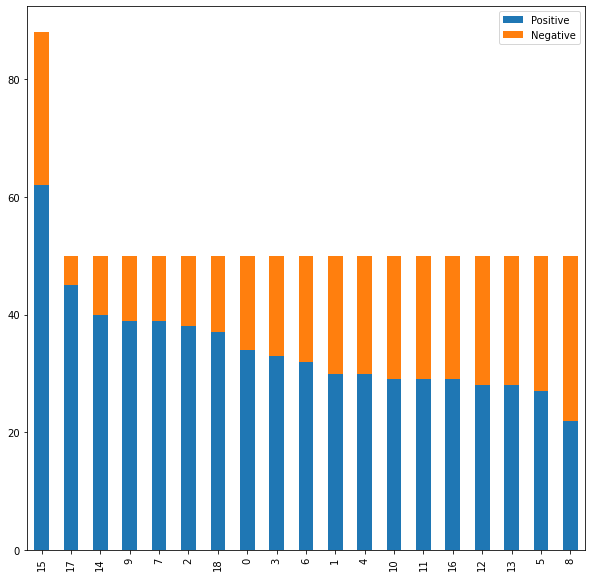

In [11]:


## remove Saints of Newark comments (scraped too many)
# df.drop(df.loc[400:437].index, inplace=True)
# df.drop(df.loc[100:149].index, inplace=True)

def binary(string, check):
    if string == check:
        return 1
    return 0

dfcount = df[['Title','Comment_Sentiment']]
dfcount['Positive'] = dfcount['Comment_Sentiment'].apply(lambda x: binary(x, 'positive'))
dfcount['Negative'] = dfcount['Comment_Sentiment'].apply(lambda x: binary(x, 'negative'))
dfcount = dfcount.drop('Comment_Sentiment', axis=1).groupby('Title').sum()
dfcount = dfcount.reset_index()
dfcount = dfcount.sort_values(by=['Positive'], ascending=False)
display(dfcount)

ax = dfcount.plot.bar(stacked=True, figsize=(10,10))
